# BASICS 03 - HOTS with online classification (Grimaldi et al. 2022)

In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm.notebook import tqdm
from hots.network import network
from hots.layer import mlrlayer
from hots.timesurface import timesurface
from hots.utils import get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, apply_jitter, printfig
import matplotlib.pyplot as plt

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
device = 'cpu'

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [4]:
type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset)
trainloader = get_loader(trainset)
testloader = get_loader(testset)
num_sample_train = len(loader)
num_sample_test = len(testloader)
print(f'number of samples in the training set: {num_sample_train}')
print(f'number of samples in the testing set: {num_sample_test}')

number of samples in the training set: 48
number of samples in the testing set: 20


## Initialization of the network

In [5]:
name = 'homeohots'
homeo = True
timestr = '2022-06-06'
dataset_name = 'poker'
n_classes = len(trainset.classes)

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e3, 4e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = hots_nohomeo.name

../Records/networks/2022-06-06_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4].pkl
../Records/networks/2022-06-06_poker_homeohots_False_[8, 16]_[1000.0, 4000.0]_[2, 4].pkl


## Unsupervised clustering

In [6]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering)

## Training of the classification layer

In [7]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 8e3

train_path = f'{hots.record_path}output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'{hots.record_path}output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'{hots.record_path}networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
results_path = f'{hots.record_path}LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, device=device, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device=device, verbose=False)

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, training=True, device=device, verbose=False)

train_path_nohomeo = f'{hots.record_path}output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'{hots.record_path}output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, device=device, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

device -> cpu


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 779.45it/s]


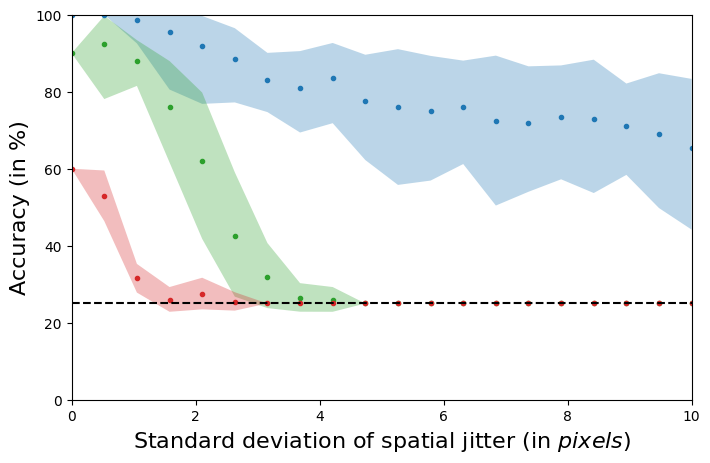

In [11]:
mlr_threshold = None

figname = 'spatial_jitter_poker.pdf'
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, mlr_threshold = mlr_threshold, fitting = False, device = device, verbose=True, figure_name = figname);

device -> cpu


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 708.52it/s]


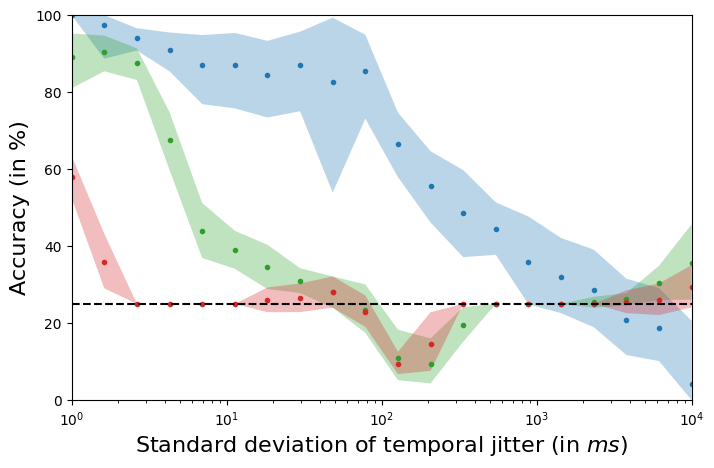

In [12]:
figname = 'temporal_jitter_poker.pdf'
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, mlr_threshold = mlr_threshold, fitting = False, device = device, verbose=True, figure_name = figname);